# Pinhole camera model calibration

The pinhole camera model is the simplest mathematical model as well as others, yet it can be applied to a lot of real photography devices. This recipe tells you how to calibrate your camera, for example, finding its intrinsic parameters and distortion coefficients.

Camera calibration aims to find two sets of intrinsic parameters: the camera matrix and distortion coefficients. The camera matrix determines how coordinates of 3D points are mapped onto dimensionless pixels coordinates in the image, but actual image lenses also distort an image so straight lines are transformed into curves. Distortion coefficients allow you to eliminate such warps.

The whole camera calibration process can be divided into three stages:

* Gathering a decent amount of data such as, images and detected chessboard patterns 
* Refining chessboard corners coordinates 
* Optimizing camera parameters to match them with observed distortions and projections

To gather data for camera calibration, you need to detect a chessboard pattern of a certain size and accumulate pairs of images and coordinates of the found corners. As you know from the ***S0408 Detecting chessboard and circles grid patterns.ipynb*** recipe from **Chapter 4**, ***Object Detection and Machine Learning***, `cv2.findChessboardCorners` implements chessboard corner detection. For more information, see **Chapter 4**, ***Object Detection and Machine Learning***. It's worth mentioning that corners on the chessboard are the ones formed by two black squares, and the pattern size you pass in `cv2.findChessboardCorners` should be the same as you have in the real chessboard pattern. The number of samples and their distribution along the field of view is also very important. In practical cases, `50` to `100` samples is enough.

The next step is refining the corner's coordinates. This stage is necessary due to the fact that `cv2.findChessboardCorners` does not give a very accurate result, so we need to find the actual corner positions. `cv2.cornerSubPix` gives
precision to corner coordinates with sub-pixel accuracy. It accepts the following arguments:

* Grayscale images 
* Coarse coordinates of detected corners 
* Size of the refine region to find a more accurate corner position 
* Size of the zone in the center of the refine region to ignore 
* Criteria to stop the refining process

Coarse coordinates of corners are the ones returned by `cv2.findChessboardCorners`. The refine region should be small, but it should include the actual position of the corner; otherwise, the coarse corner is returned. The size of the zone to ignore should be smaller than the refine region and can be disabled by passing $(-1, -1)$ as its value. The stop criteria can be one of the following types, `cv2.TERM_CRITERIA_EPS` or `cv2.TERM_CRITERIA_MAX_ITER`, or a combinationof the two. `cv2.TERM_CRITERIA_EPS` determines the difference in previous and next corner positions. If the actual difference is less than the one defined, the process will be stopped. `cv2.TERM_CRITERIA_MAX_ITER` determines the maximum number of iterations. `cv2.cornerSubPix` returns the same number of corners with refined coordinates.

Once we have refined the corner's positions, it's time to find the camera's parameters. `cv2.calibrateCamera` solves this problem. You need to pass a few parameters to this function, and these are listed as follows:

* Object points coordinates for all samples 
* Corners points coordinates for all samples 
* Shape of the images in (width, height) format 
* Two arrays to save translation and rotation vectors (can be set to None) 
* Flags and stop criteria (both have default values)


Object points are 3D coordinates of chessboard corners in a chessboard coordinate system. Because we use the same pattern for each frame, the 3D coordinates of the corners are the same and, because we use equidistantly distributed corners, 3D coordinates are also equidistantly distributed on the plane ($z=0$ for all points). The actual distance between corners doesn't matter because the camera eliminates the $z$ coordinate (how far objects are from the camera), so it can be a smaller but closer pattern, or a bigger but farther one—the image is the same. `cv2.calibrateCamera` returns five values: the mean reprojection error for all samples, the camera matrix, distortion coefficients, rotation, and translation vectors for all samples. The reprojection error is the difference between a corner in the image and the projection of a 3D point of the corner. Ideally, the projection of the corner and its original position in the image should be the same, but there is a difference due to the noise. This difference is measured in pixels. The smaller this difference is, the better the calibration is done. The camera matrix has a shape of $3\times 3$. The number of distortion coefficients depends on the flags and it equals $5$ by default.

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)

#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  image_chess--------------    Shape(240, 320, 3) image_chess: uint8
[[188 188 188] [186 186 186] [187 187 187] [187 187 187] [186 186 186] [186 186 186] [187 187 187] ]
[[188 188 188] [188 188 188] [188 188 188] [188 188 188] [188 188 188] [189 189 189] [189 189 189] ]
[[190 190 190] [190 190 190] [190 190 190] [190 190 190] [190 190 190] [190 190 190] [190 190 190] ]
[[190 190 190] [190 190 190] [190 190 190] [190 190 190] [190 190 190] [190 190 190] [191 191 191] ]


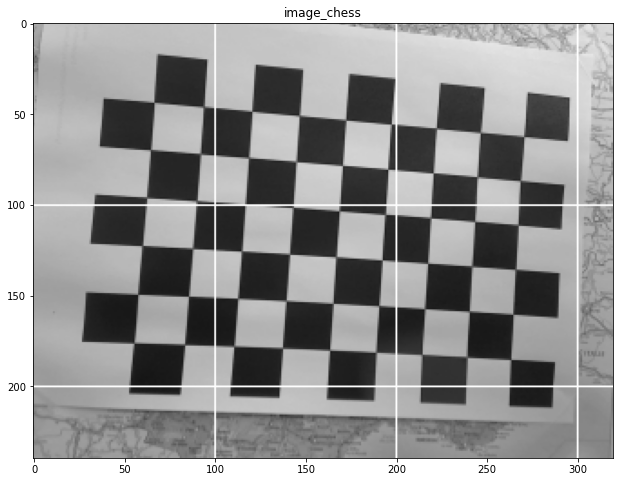

In [10]:
image_chess = cv2.imread('../data/chessboard.png')


############################################################
print_image('image_chess','image_chess',image_chess,50,54,70,77)
plt_view_image(plt,[["image_chess",draw_grid(np.copy(image_chess),100,(255,255,255))[:,:,[2,1,0]] ]], 
               figsize=(15,8), axis='on', cmap='gray')

In [2]:
cap = cv2.VideoCapture(0)

pattern_size = (10, 7)

samples = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    res, corners = cv2.findChessboardCorners(frame, pattern_size)
    
    img_show = np.copy(frame)
    cv2.drawChessboardCorners(img_show, pattern_size, corners, res)
    cv2.putText(img_show, 'Samples captured: %d' % len(samples), (0, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    cv2.imshow('chessboard', img_show)
    
    wait_time = 0 if res else 30
    k = cv2.waitKey(wait_time)
    
    if k == ord('s') and res:
        samples.append((cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), corners))
    elif k == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [3]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

for i in range(len(samples)):
    img, corners = samples[i]
    corners = cv2.cornerSubPix(img, corners, (10, 10), (-1,-1), criteria)

In [4]:
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

images, corners = zip(*samples)

pattern_points = [pattern_points]*len(corners)

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(pattern_points,corners, 
                                                                   images[0].shape, None, None)

np.save('camera_mat.npy', camera_matrix)
np.save('dist_coefs.npy', dist_coefs)

ValueError: not enough values to unpack (expected 2, got 0)